In [4]:
import netket as nk
import optax
import jax

# 2D Lattice
g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)

# Hilbert space of spins on the graph
hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes)

# Ising spin hamiltonian at the critical point
ha = nk.operator.Ising(hilbert=hi, graph=g, h=3.0)

# RBM Spin Machine
ma = nk.models.RBM(alpha=1, use_visible_bias=True, param_dtype=float)

# Metropolis Local Sampling
sa = nk.sampler.MetropolisLocal(hi, n_chains=16)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008, n_discard_per_chain=10)
vs.init_parameters(jax.nn.initializers.normal(stddev=0.01), seed=1234)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=optax.linear_schedule(0.01, 0.0001, 1000))

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.001)

# Variational monte carlo driver
gs = nk.VMC(ha, op, variational_state=vs, preconditioner=sr)

# Create a JSON output file, and overwrite if file exists
logger = nk.logging.JsonLog("test", "w")

# Run the optimization
gs.run(n_iter=1000, out=logger)

100%|██████████| 1000/1000 [00:29<00:00, 33.79it/s, Energy=-51.4520 ± 0.0040 [σ²=0.0163, R̂=1.0076]]


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.13211512565612793
   	Params: 0.010381937026977539,)

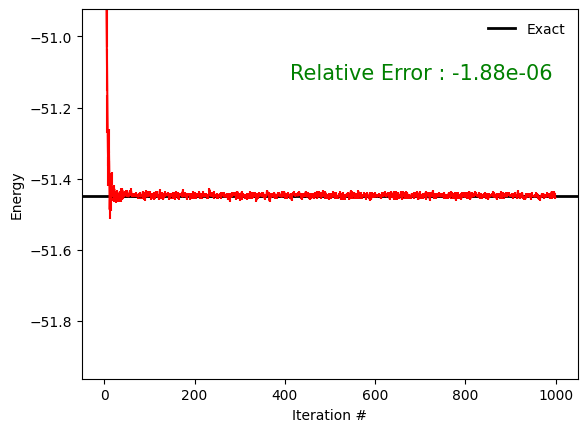

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import json

plt.ion()

# 4x4 lattice
exact=-3.21550807082536*16

# 5x5 lattice
# exact = -80.13310152422413


plt.clf()
plt.ylabel("Energy")
plt.xlabel("Iteration #")

data = json.load(open("test.log"))
iters = data["Energy"]["iters"]
energy = data["Energy"]["Mean"]
sigma = data["Energy"]["Sigma"]
evar = data["Energy"]["Variance"]

nres = len(iters)
cut = 60
if nres > cut:
    fitx = iters[-cut:-1]
    fity = energy[-cut:-1]
    z = np.polyfit(fitx, fity, deg=0)
    p = np.poly1d(z)

    # plt.xlim([nres - cut, nres])
    maxval = np.max(energy[-cut:-1])
    plt.ylim([exact - (np.abs(exact) * 0.01), maxval + np.abs(maxval) * 0.01])
    error = (z[0] - exact) / -exact
    plt.gca().text(
        0.95,
        0.8,
        f"Relative Error : {error:.2e}",
        verticalalignment="bottom",
        horizontalalignment="right",
        color="green",
        fontsize=15,
        transform=plt.gca().transAxes,
    )

    plt.plot(fitx, p(fitx))

plt.errorbar(iters, energy, yerr=sigma, color="red")
plt.axhline(y=exact, xmin=0, xmax=iters[-1], linewidth=2, color="k", label="Exact")

plt.legend(frameon=False)